## VAE 

In [ ]:
import torch 
import os 

train_data_file = 'train_data.pt'
train_labels_file = 'train_labels.pt'
test_data_file = 'test_data.pt'
test_labels_file = 'test_labels.pt'
zip_filename = 'colored_mnist.zip'

zip_path = '/kaggle/working/' + zip_filename

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"{zip_filename} not found in /kaggle/working/. Please ensure the ZIP file is uploaded.")

with zipfile.ZipFile(zip_path, 'r') as zipf:
    zipf.extractall('/kaggle/working/')

print(f"Extracted {zip_filename}.")

train_data = torch.load(os.path.join('/kaggle/working/', train_data_file))
train_labels = torch.load(os.path.join('/kaggle/working/', train_labels_file))
test_data = torch.load(os.path.join('/kaggle/working/', test_data_file))
test_labels = torch.load(os.path.join('/kaggle/working/', test_labels_file))

print("Loaded train and test datasets from the ZIP file.")

os.remove(os.path.join('/kaggle/working/', train_data_file))
os.remove(os.path.join('/kaggle/working/', train_labels_file))
os.remove(os.path.join('/kaggle/working/', test_data_file))
os.remove(os.path.join('/kaggle/working/', test_labels_file))

print("Individual .pt files removed after loading.")


Extracted colored_mnist.zip.


/tmp/ipykernel_30/2492188801.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join('/kaggle/working/', train_data_file))


Loaded train and test datasets from the ZIP file.
Individual .pt files removed after loading.


/tmp/ipykernel_30/2492188801.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_labels = torch.load(os.path.join('/kaggle/working/', train_labels_file))
/tmp/ipykern

In [37]:
print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")


Train data shape: torch.Size([60000, 3, 28, 28])
Train labels shape: torch.Size([60000])
Test data shape: torch.Size([10000, 3, 28, 28])
Test labels shape: torch.Size([10000])


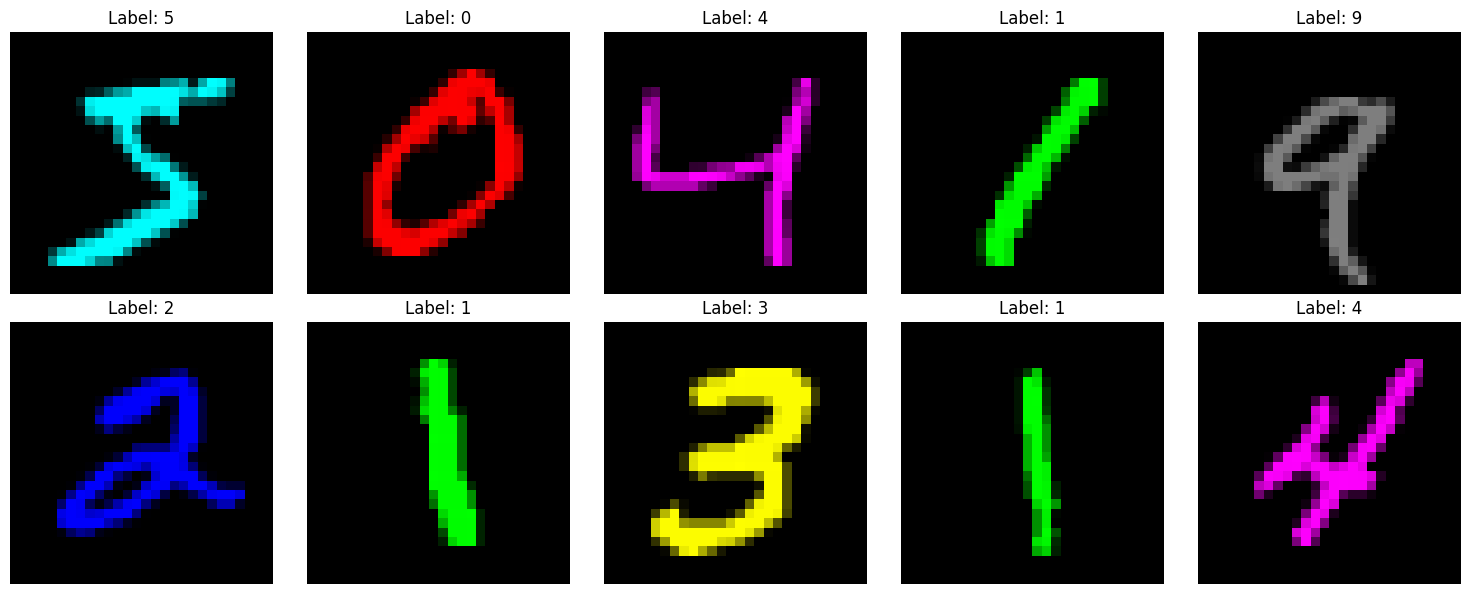

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axs.flat):

    ax.imshow(train_data[i].permute(1, 2, 0).numpy())

    ax.set_title(f"Label: {train_labels[i].item()}")

    ax.axis('off')

plt.tight_layout()

plt.show()


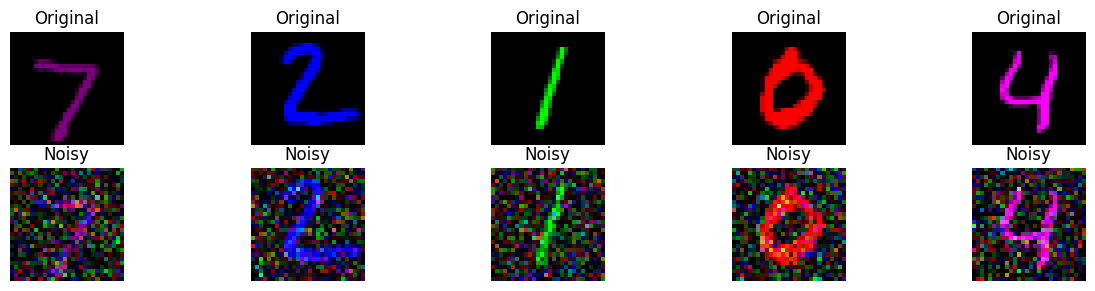

In [ ]:
def add_gaussian_noise(images, sigma=0.1):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

sigma = 0.3
train_noisy = add_gaussian_noise(train_data, sigma)
test_noisy = add_gaussian_noise(test_data, sigma)

def show_images(original, noisy, denoised=None, num=5):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        ax = plt.subplot(3, num, i + 1)
        plt.imshow(original[i].permute(1, 2, 0).numpy())
        plt.title("Original")
        plt.axis('off')

        ax = plt.subplot(3, num, i + 1 + num)
        plt.imshow(noisy[i].permute(1, 2, 0).numpy())
        plt.title("Noisy")
        plt.axis('off')

        if denoised is not None:
            ax = plt.subplot(3, num, i + 1 + 2*num)
            plt.imshow(denoised[i].permute(1, 2, 0).detach().cpu().numpy())
            plt.title("Denoised")
            plt.axis('off')
    plt.show()

show_images(test_data, test_noisy)


## VAE 

In [ ]:
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

train_noisy = train_noisy.to(device)
train_data = train_data.to(device)
test_noisy = test_noisy.to(device)
test_data = test_data.to(device)

batch_size = 128
train_loader = DataLoader(torch.utils.data.TensorDataset(train_noisy, train_data, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(test_noisy, test_data, test_labels), batch_size=batch_size, shuffle=False)


Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),  # [128,14,14]
            nn.ReLU(True),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1), # [64,7,7]
            nn.ReLU(True),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),  # [32,4,4]
            nn.ReLU(True),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),  # [16,2,2]
            nn.ReLU(True)
        )
        
        self.fc_mu = nn.Linear(16*2*2, 20)  # Mean vector
        self.fc_var = nn.Linear(16*2*2, 20)  # Variance vector
        
        # Decoder
        self.fc_decode = nn.Linear(20, 16*2*2)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32,4,4]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64,8,8]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # [128,16,16]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # [3,32,32]
            nn.Sigmoid()  # Output between 0 and 1
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        
        # Latent variables
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        z = self.reparameterize(mu, log_var)
        
        # Decoder
        x = self.fc_decode(z)
        x = x.view(x.size(0), 16, 2, 2)
        x = self.decoder(x)
        x = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)
        
        return x, mu, log_var


vae_model = VAE()
print(vae_model)


vae_model = vae_model.to(device)

def vae_loss(recon_x, x, mu, log_var):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kld_loss

optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-5)


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc_mu): Linear(in_features=64, out_features=20, bias=True)
  (fc_var): Linear(in_features=64, out_features=20, bias=True)
  (fc_decode): Linear(in_features=20, out_features=64, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2)

In [ ]:
def show_noisy_vs_denoised_at_epoch(epoch, model, num=5):
    model.eval()
    idx = torch.randint(0, len(test_data), (num,))
    noisy_images = test_noisy[idx]

    with torch.no_grad():
        denoised_images, _, _ = model(noisy_images)

    show_noisy_vs_denoised(noisy_images.cpu(), denoised_images.cpu(), num=num, epoch=epoch)


Epoch [1/20], Train Loss: 12898.617087, Test Loss: 9660.784554
Epoch [2/20], Train Loss: 8547.345500, Test Loss: 6747.250108


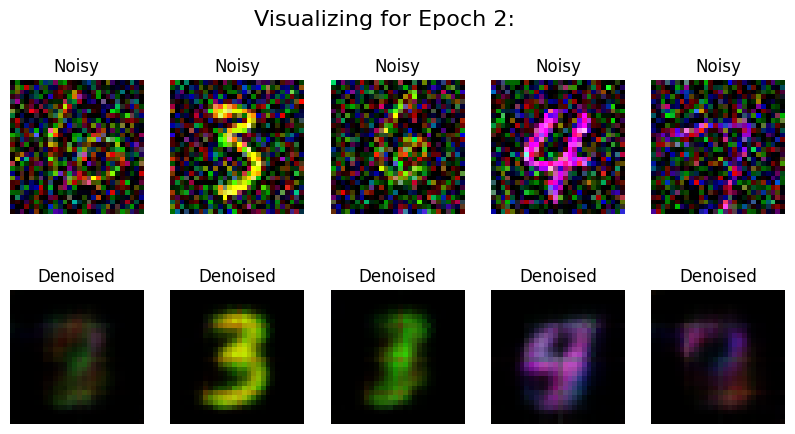

Epoch [3/20], Train Loss: 6000.749127, Test Loss: 5474.183727
Epoch [4/20], Train Loss: 5346.103958, Test Loss: 5174.135446


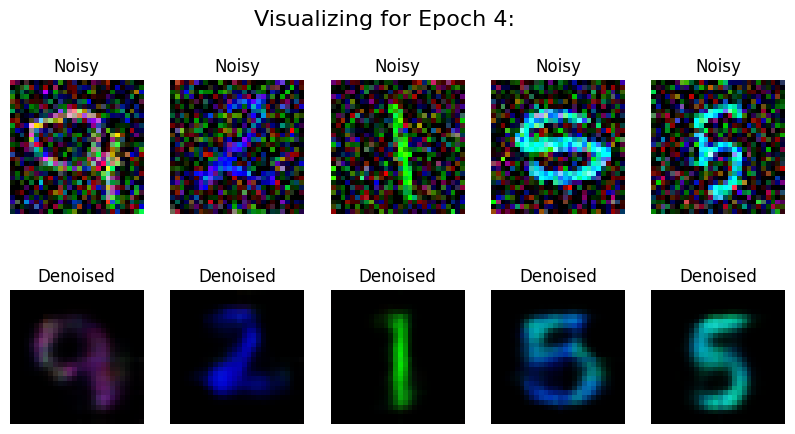

Epoch [5/20], Train Loss: 5093.013091, Test Loss: 4967.071113
Epoch [6/20], Train Loss: 4937.270160, Test Loss: 4823.643556


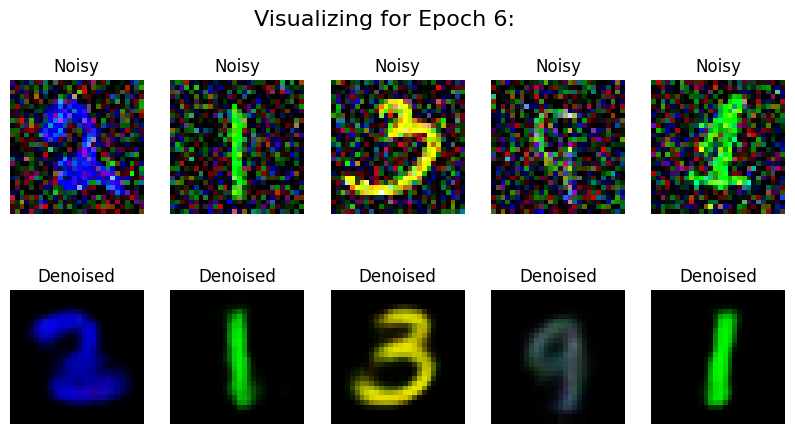

Epoch [7/20], Train Loss: 4827.073870, Test Loss: 4775.020125
Epoch [8/20], Train Loss: 4740.036924, Test Loss: 4653.818255


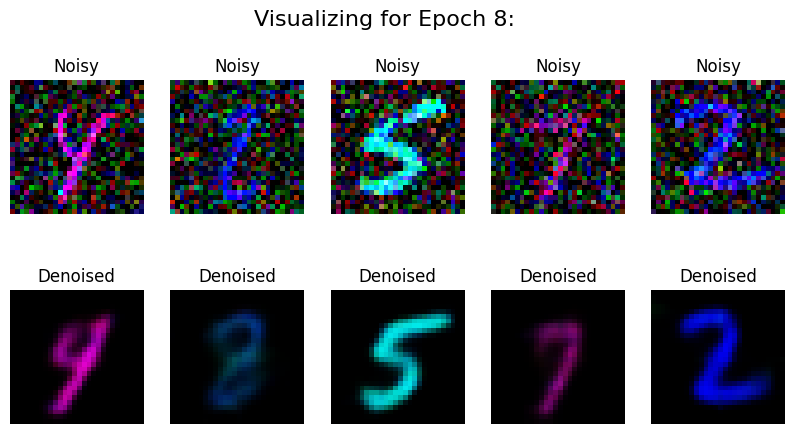

Epoch [9/20], Train Loss: 4657.140143, Test Loss: 4573.764143
Epoch [10/20], Train Loss: 4591.996601, Test Loss: 4541.390898


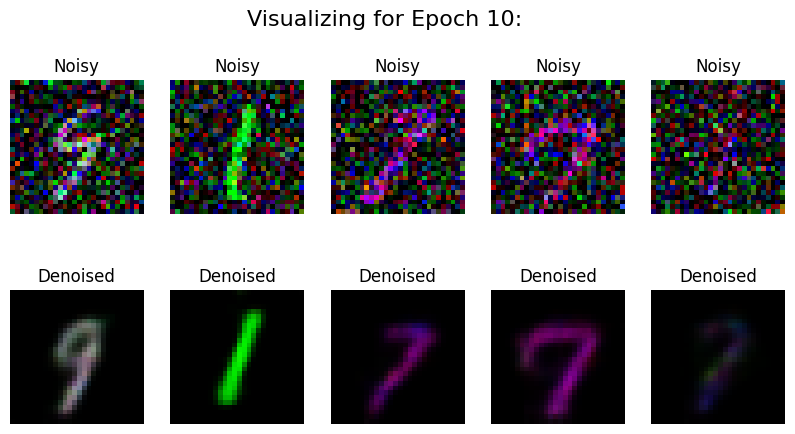

Epoch [11/20], Train Loss: 4539.808037, Test Loss: 4492.791252
Epoch [12/20], Train Loss: 4494.859476, Test Loss: 4427.915102


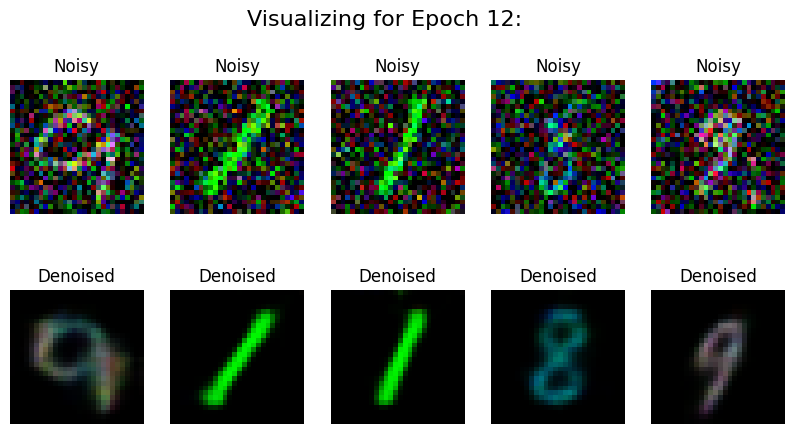

Epoch [13/20], Train Loss: 4455.288361, Test Loss: 4403.578439
Epoch [14/20], Train Loss: 4426.223826, Test Loss: 4354.934027


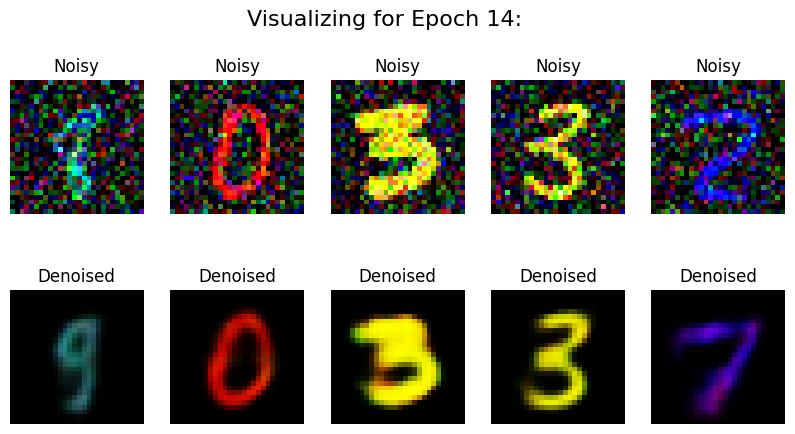

Epoch [15/20], Train Loss: 4397.082636, Test Loss: 4367.685854
Epoch [16/20], Train Loss: 4370.985546, Test Loss: 4336.360313


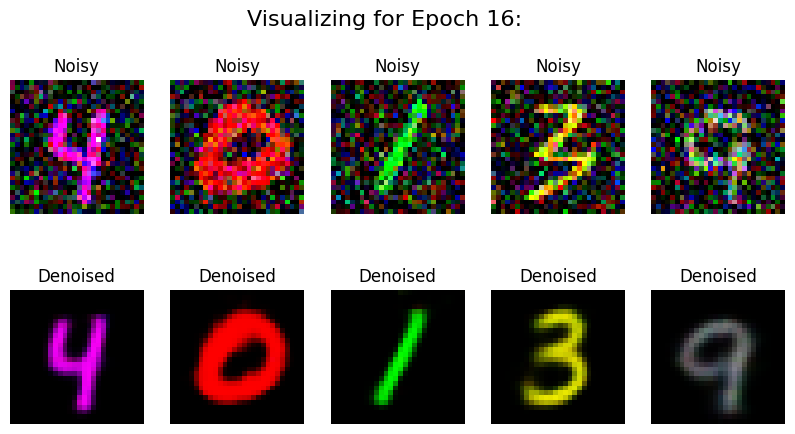

Epoch [17/20], Train Loss: 4346.131829, Test Loss: 4292.242141
Epoch [18/20], Train Loss: 4335.049462, Test Loss: 4309.132210


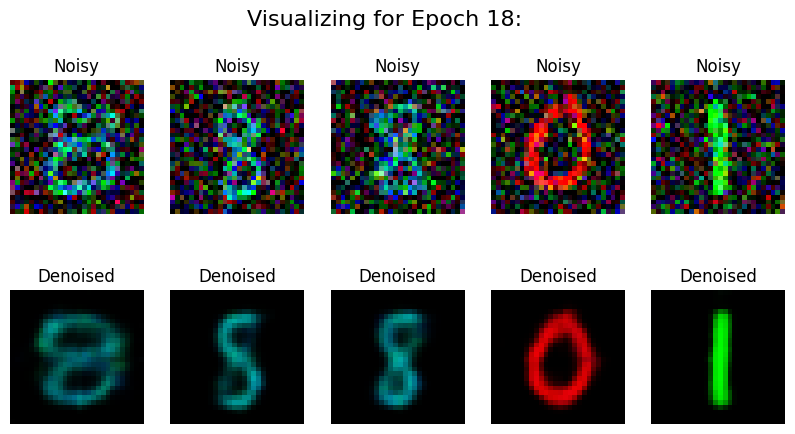

Epoch [19/20], Train Loss: 4312.911156, Test Loss: 4262.334755
Epoch [20/20], Train Loss: 4290.796328, Test Loss: 4253.732086


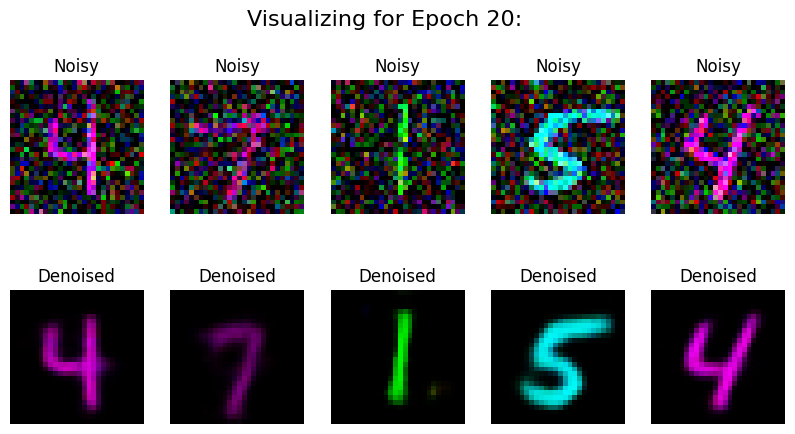

In [ ]:
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    vae_model.train()
    running_loss = 0.0
    for data in train_loader:
        inputs, targets, labels = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        recon_x, mu, log_var = vae_model(inputs)
        loss = vae_loss(recon_x, targets, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    vae_model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, targets, labels = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            recon_x, mu, log_var = vae_model(inputs)
            loss = vae_loss(recon_x, targets, mu, log_var)
            test_running_loss += loss.item() * inputs.size(0)
    
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_losses.append(test_epoch_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.6f}, Test Loss: {test_epoch_loss:.6f}")

    if (epoch + 1) % 4 == 0:
        show_noisy_vs_denoised_at_epoch(epoch + 1, vae_model)


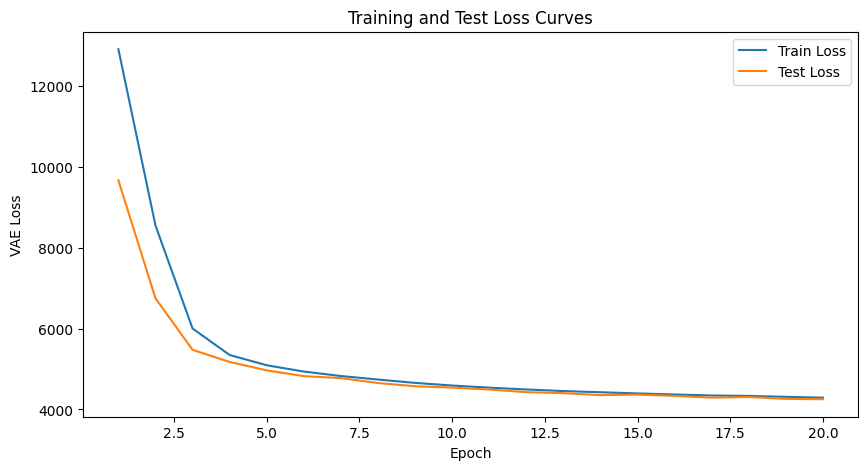

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('VAE Loss')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()

In [ ]:
def get_latent_vectors(model, data_loader, device, num_batches=5):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch_idx, data in enumerate(data_loader):
            if batch_idx >= num_batches:
                break

            inputs, _, targets = data
            inputs = inputs.to(device)

            _, mu, _ = model(inputs)
            
            latent_vectors.append(mu.cpu().numpy())
            labels.append(targets.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_vectors, labels

latent_vectors, labels = get_latent_vectors(vae_model, test_loader, device, num_batches=100)

print(f"Latent vectors shape: {latent_vectors.shape}")
print(f"Labels shape: {labels.shape}")


Latent vectors shape: (10000, 20)
Labels shape: (10000,)


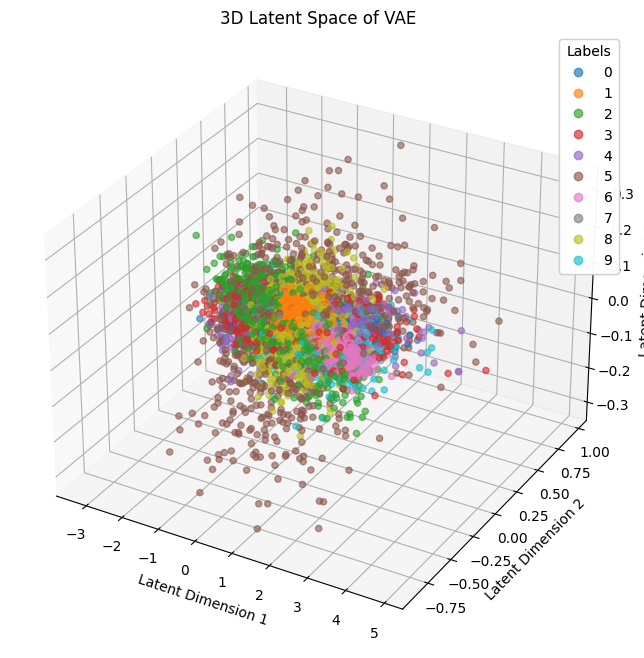

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space_3d(latent_vectors, labels):
    fig = plt.figure(figsize=(10, 8))
    
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], latent_vectors[:, 2],
                         c=labels, cmap='tab10', alpha=0.6)
    
    legend = ax.legend(*scatter.legend_elements(), title="Labels")
    ax.add_artist(legend)
    
    ax.set_title('3D Latent Space of VAE')
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_zlabel('Latent Dimension 3')
    
    plt.show()

plot_latent_space_3d(latent_vectors, labels)


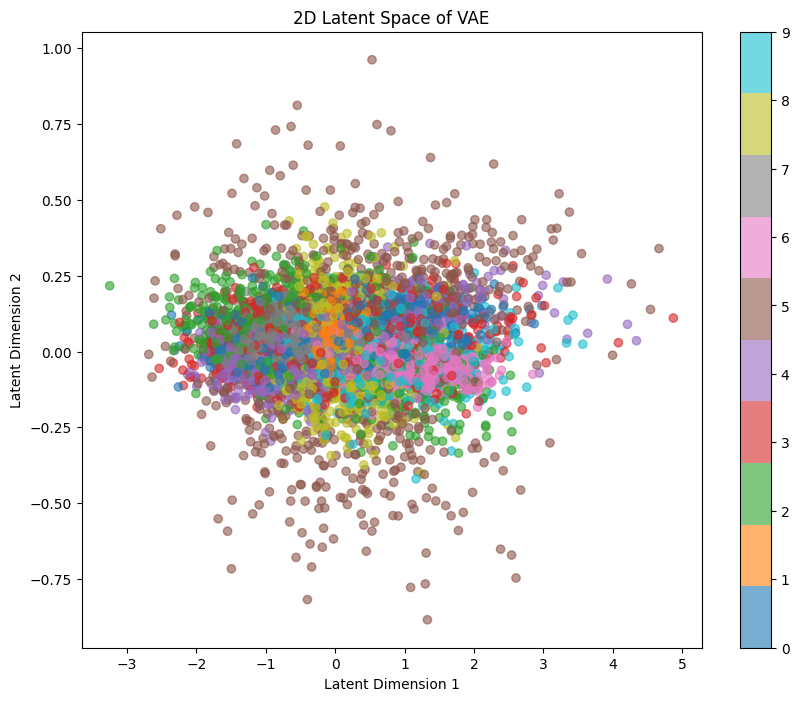

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space_2d(latent_vectors, labels):
    plt.figure(figsize=(10, 8))
    
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar()
    
    plt.title('2D Latent Space of VAE')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    
    plt.show()

plot_latent_space_2d(latent_vectors, labels)


END 